# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A Many-objective Genetic Algorithm is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

** Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score **

In [1]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)



** Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this.
What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [2]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

from dps_lake_model import lake_model

model = Model('lakeproblem', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
# note how we need to explicitely indicate the direction
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]



In [3]:
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=500,
                                            policies=4,
                                            uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


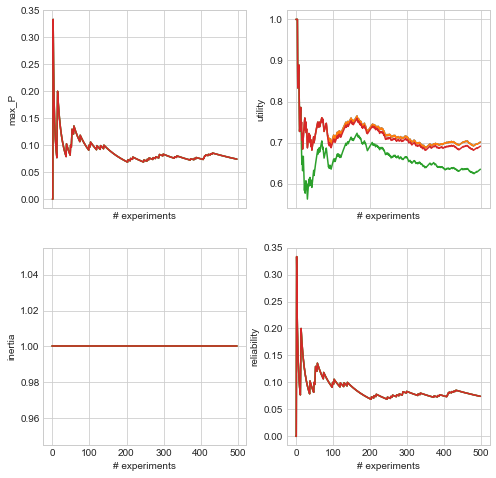

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

robustness_funcs = {"max_P": maxp,
                    "utility": utility,
                    "inertia": inertia,
                    "reliability": reliability}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
        # data.shape should be (500,), given n_scenarios=500
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)


what we are analysing here is how our estimate of robustness converges to the `true` robustness value as a function of the number of experiments used to calculate it. This is most notable for utility, where we can also see the different for the different policies. Judging on the basis of these plots, we would need at least 200, but probably closer to 500 scenarios to reliably estimate our robustness. 

## Searching for candidate solutions

See the MORDM assignment for setting up platypus.

Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [6]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 50
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(1e4)

**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

In [7]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [ScalarOutcome('fraction max_p', kind=MAXIMIZE, 
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('fraction reliability', kind=MAXIMIZE, 
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('fraction inertia', kind=MAXIMIZE, 
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('fraction utility', kind=MAXIMIZE, 
                             variable_name='utility', function=utility)]

In [8]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

# requires master branch of workbench
# enables us to avoid logging to many intermediate results
# can be ignored without invalidating results
BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)

convergence = [HyperVolume(minimum=[0,0,0,0], maximum=[1, 1, 1, 1]),
               EpsilonProgress()]

with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, 
                                               nfe=nfe, convergence=convergence,
                                               epsilons=[0.05,]*len(robustnes_functions))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 98 policies * 1 model(s) = 4900 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 99 policies * 1 model(s) = 4950 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 397/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 99 policies * 1 model(s) = 4950 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] performing 50 scenario

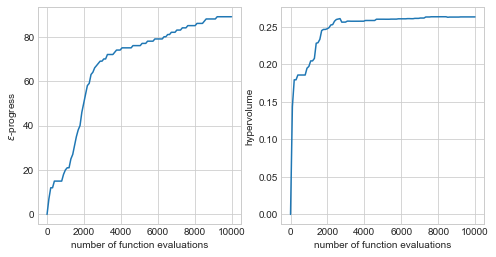

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

Judging by hypervolume, we appear to have converged (hypervolume seems to be stable). Still, time permitting, it would be good to run the optimization even longer. 

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


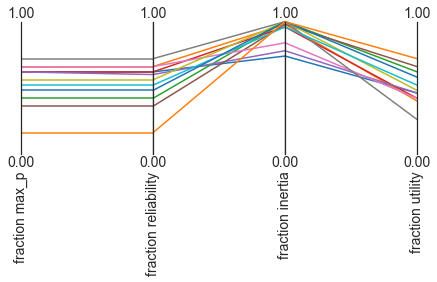

In [10]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

The basic structure of the robustness scores is quite similar. All are quite robust (i.e. score of 1) for intertia, with lower values on the other scores. Note how the grey line that has the highest robustness on `fraction max_P` and `fraction utility` scores less well on `fraction utility`. There thus appears to be a negative correlation between the first two and the last objective. 

## Step 3: Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios).

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [22]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [12]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 12 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


 How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

In [15]:
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,inertia,max_P,reliability,utility
moro 0,0.789,0.569,0.540,0.452
moro 1,0.979,0.602,0.598,0.413
moro 10,1.000,0.446,0.446,0.561
moro 11,1.000,0.183,0.176,0.700
moro 2,1.000,0.392,0.389,0.613
moro 3,0.927,0.592,0.590,0.425
moro 4,0.793,0.562,0.538,0.465
moro 5,0.964,0.373,0.361,0.631
moro 6,0.813,0.599,0.591,0.438
moro 7,0.984,0.647,0.644,0.306


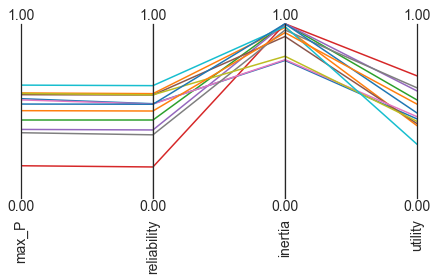

In [18]:

# we pass the column labels explicitly to ensure the same order
# as in the previous plot
data = overall_robustness.loc[:, 
                              ['max_P', 'reliability', 'inertia', 'utility']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

Interestingly, the pattern of scores is actually quite similar. We optimized over 50 scenarios, while the re-evaluation used 500 scenarios. 

Based on the first figures you made in this assignment, this might be surprising. The main reason why this is has to do with the difference in space filling properties of latin hypercube sampling versus monte carlo sampling


## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?

In [23]:
mordm_policies = pd.read_csv('mordm filtered polices.csv', index_col=0)

for i, policy in mordm_policies.iterrows():
    policies_to_evaluate.append(Policy("mordm {}".format(i), **policy.to_dict()))

We need to rerun the analysis. A fair comparison requires that we look at the results using the same set of scenarios. We can thus not simply reuse either the foregoing results in this notebook of the results from the mordm notebook. 

In [24]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    re_evaluation_results = evaluator.perform_experiments(n_scenarios,
                                                          policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 16 policies * 1 model(s) = 16000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 11200 cases completed
[MainProcess/INFO] 12800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [26]:
experiments, outcomes = re_evaluation_results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,inertia,max_P,reliability,utility
mordm 1,1.000,0.669,0.668,0.116
mordm 3,1.000,0.669,0.666,0.172
mordm 5,0.822,0.461,0.392,0.388
mordm 8,0.818,0.396,0.337,0.384
moro 0,0.794,0.583,0.541,0.440
moro 1,0.956,0.609,0.607,0.396
moro 10,1.000,0.469,0.467,0.539
moro 11,1.000,0.183,0.179,0.705
moro 2,1.000,0.393,0.388,0.606
moro 3,0.920,0.606,0.605,0.409


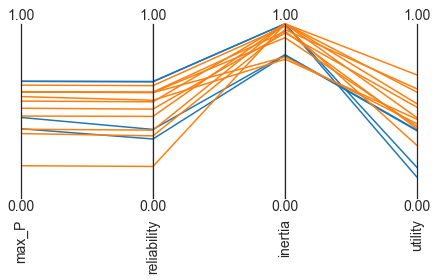

In [32]:

# we pass the column labels explicitly to ensure the same order
# as in the previous plot

mordm_policies = ['mordm 1', 'mordm 3', 'mordm 5', 'mordm 8']
moro_policies = ['moro 1', 'moro 10', 'moro 11', 'moro 2', 'moro 3', 
                 'moro 4', 'moro 5', 'moro 6', 'moro 7', 'moro 8', 
                 'moro 9']
colors = sns.color_palette()

data = overall_robustness.loc[:, 
                              ['max_P', 'reliability', 'inertia', 'utility']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data.loc[mordm_policies,:], color=colors[0])
paraxes.plot(data.loc[moro_policies,:], color=colors[1])
plt.show()